In [3]:
#from influxdb import InfluxDBClient
import gmaps
import numpy as np
import gmaps.datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import influxdb
import requests
from datetime import datetime as dt
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [14]:
auth = pd.read_json('../auth.json',typ='series')
client = influxdb.DataFrameClient(auth.influxdb['hostname'], 8086, ssl=True, username=auth.influxdb['username'], password=auth.influxdb['password'])

# set up pm data

In [23]:
coords = client.query("select * from coords", database="sensenet_coords")
userData = coords['coords']
userData = userData.reset_index(drop=True)
userData=userData.rename(columns={"box":"dev_id"})
userData.dev_id=[(int)(x.split('x')[-1]) for x in userData.dev_id]
userData

,dev_id,latitude,longitude,type,uid
0,11,38.029883,-78.484047,outdoor,LF
1,10,38.030613,-78.479057,outdoor,CCI
2,9,38.025759,-78.469295,outdoor,Jon K.
3,8,38.047450,-78.483030,outdoor,Angela O.
4,7,38.025570,-78.516610,outdoor,Lane R.
5,6,38.025092,-78.503586,outdoor,Jimmy H.
6,5,38.045801,-78.503947,outdoor,Francis R.
7,4,38.027580,-78.515191,outdoor,Alex N.
8,3,38.024780,-78.484580,outdoor,Lucas A.
9,2,38.065460,-78.495820,outdoor,Zihao Z.


In [38]:
complete_df = client.query("select * from \"sensenet-test\"", database="sensornet_db")
pmData = complete_df['sensenet-test']
pmData[['dev_id','pm25', 'pm10', 'co2', 'temp', 'humidity', 'gtw_id', 'rssi', 'snr']].head()
boxes = ['sbox'+str(i) for i in range(2,12)]
pmData = pmData[pmData.dev_id.isin(boxes)]
pmData.dev_id=[(int)(x.split('x')[-1]) for x in pmData.dev_id]
pmData=pmData.join(userData,on='dev_id',rsuffix='_user',how="outer")
pmData

,airtime,channel,co2,data_rate,dev_id,frequency,gtw_id,humidity,latitude,longitude,...,pm25,rssi,snr,temp,timestamp,dev_id_user,latitude_user,longitude_user,type,uid
2020-02-03 00:36:03.779007152+00:00,61696000.0,3.0,144.0,SF7BW125,6,904.5,sds-gateway-3,62.89,38.026337,-78.50461,...,0.0,-14.0,9.00,12.52,4.366491e+08,5.0,38.045801,-78.503947,outdoor,Francis R.
2020-02-03 00:51:03.804609070+00:00,61696000.0,7.0,140.0,SF7BW125,6,905.3,sds-gateway-3,62.82,38.026337,-78.50461,...,0.0,-15.0,9.00,12.82,1.336640e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
2020-02-03 01:06:04.829307469+00:00,61696000.0,5.0,149.0,SF7BW125,6,904.9,sds-gateway-3,62.14,38.026337,-78.50461,...,0.0,-15.0,10.75,13.17,2.237630e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
2020-02-03 01:21:03.771676500+00:00,61696000.0,4.0,144.0,SF7BW125,6,904.7,sds-gateway-3,61.29,38.026337,-78.50461,...,0.0,-16.0,10.00,13.51,3.136621e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
2020-02-03 01:36:03.768423914+00:00,61696000.0,5.0,132.0,SF7BW125,6,904.9,sds-gateway-3,60.77,38.026337,-78.50461,...,0.0,-13.0,10.50,13.63,4.036612e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 14:43:09.374247967+00:00,28288000.0,8.0,462.0,SF8BW500,5,904.6,eui-60c5a8fffe766154,86.29,NaN,NaN,...,10.0,-49.0,10.50,10.00,1.353179e+09,6.0,38.025092,-78.503586,outdoor,Jimmy H.
2020-02-25 14:58:09.388902175+00:00,28288000.0,8.0,468.0,SF8BW500,5,904.6,eui-60c5a8fffe766154,86.03,NaN,NaN,...,10.0,-51.0,10.80,10.26,2.253170e+09,6.0,38.025092,-78.503586,outdoor,Jimmy H.
2020-02-25 15:13:09.355555654+00:00,28288000.0,8.0,454.0,SF8BW500,5,904.6,eui-60c5a8fffe766154,85.80,NaN,NaN,...,10.0,-51.0,10.80,10.05,3.153161e+09,6.0,38.025092,-78.503586,outdoor,Jimmy H.
NaT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.0,38.029883,-78.484047,outdoor,LF


In [6]:
#why are there multiple formats here?
datetimes = pd.DataFrame(columns=['DateTime'])
for x in pmData.time:
    try:
        test=dt.strptime(x[0:-11],'%Y-%m-%dT%H:%M:%S')
    except:
        try:
            test=dt.strptime(x,'%m/%d/%Y %H:%M:%S %p')
        except:
            continue
    datetimes = datetimes.append({'DateTime':test},ignore_index=True)

In [7]:
pmData['DateTime']=datetimes.DateTime

In [16]:
pmData['DateTime']=[pd.Timestamp(x) for x in pmData.DateTime]

In [17]:
pmData.dtypes

time                      object
airtime                  float64
channel                  float64
co2                      float64
data_rate                 object
dev_id                     int64
frequency                float64
gtw_id                    object
humidity                 float64
latitude                 float64
longitude                float64
pm10                     float64
pm25                     float64
rssi                     float64
snr                      float64
temp                     float64
timestamp                float64
time_user                 object
dev_id_user              float64
latitude_user            float64
longitude_user           float64
type                      object
uid                       object
DateTime          datetime64[ns]
dtype: object

# set up weather data

In [8]:
pwsIDs = [105, 171, 111, 136, 112, 80, 106, 176, 134, 8]

In [9]:
geo = pd.read_csv('geo.csv')

In [10]:
weatherData = pd.read_csv("../data/2020-01-01,2020-02-22.csv")

In [11]:
weatherData=weatherData.join(geo.set_index('pws'),on="pws")

In [12]:
weatherData['DateTime']=[dt.datetime.strptime(x,'%Y-%m-%d %I:%M %p') for x in (weatherData.date + " " + weatherData.Time)]

In [13]:
weatherData.head()

,Unnamed: 0,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,...,UV,Solar,date,pws,lat,lat_dir,long,long_dir,elevation,DateTime
0,1,12:04 AM,41.5 F,27.5 F,57 %,NE,0.0 mph,0.0 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:04:00
1,2,12:09 AM,41.5 F,27.5 F,57 %,NE,0.0 mph,0.0 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:09:00
2,3,12:14 AM,41.4 F,27.6 F,58 %,ESE,0.1 mph,0.2 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:14:00
3,4,12:19 AM,41.2 F,27.9 F,59 %,SE,0.0 mph,0.2 mph,29.20 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:19:00
4,5,12:24 AM,41.0 F,27.9 F,59 %,SE,0.0 mph,0.0 mph,29.20 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:24:00


# testing stuff

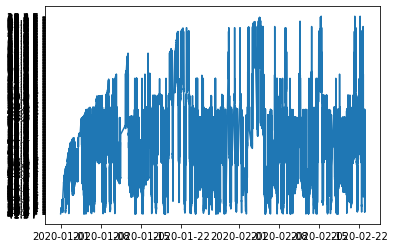

In [48]:
plt.plot(weatherData[weatherData.pws==171.0].DateTime,weatherData[weatherData.pws==171.0].Temperature)

In [ ]:
gmaps.configure(api_key=auth.gmaps['api_key']) # Your Google API key

In [ ]:
#weather data one reading per 5 mins
#pm data one reading per 15 mins
#must move through time and for each 5 mins get the closest data point for each weather station and each AQ station
#each row has predictors from all stations with one AQ station removed
#thus we have the same # of rows as the weather data because 1 row for each of the 10 stations is combined into 1 row
#all of the AQ data is applied, and then it is multiplied out by 10 for predicting each of the AQ stations

In [176]:
pmData=pmData.sort_values(by=['DateTime'])
weatherData=weatherData.sort_values(by=['DateTime'])